In [78]:
import keras
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.filterwarnings('ignore')

In [91]:
np.random.seed(1337)
random.seed(1337)

## Read ESC-50 metadata

In [7]:
meta_data = pd.read_csv('./ESC-50-master/meta/esc50.csv')

In [9]:
print(meta_data.shape)
meta_data.head()

(2000, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Visualizing a dog audio sample via melspectrogram

In [28]:
y, sr = librosa.load('./ESC-50-master/audio/1-100032-A-0.wav')
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 216)

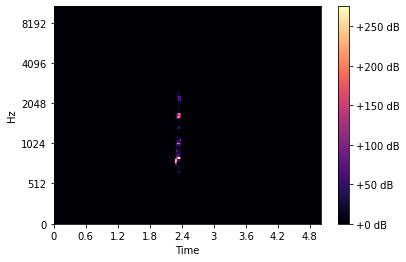

In [38]:
librosa.display.specshow(ps, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

## Create melspectrogram for each audio clip

In [116]:
data = []

for row in meta_data.iterrows():
    y, sr = librosa.load('./ESC-50-master/audio/' + row[1].filename)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    assert ps.shape == (128, 216)
    data.append((ps, row[1].target))

In [75]:
data = np.array(data)
data.shape

(2000, 2)

In [108]:
data[0]

array([array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
       0], dtype=object)

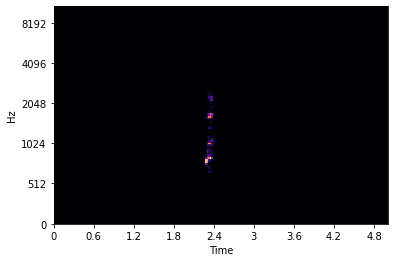

In [77]:
librosa.display.specshow(data[0][0], x_axis='time', y_axis='mel')

## Split dataset into train, validation, and test

In [117]:
X, y = zip(*data)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

In [126]:
X_train_ = np.array([x.reshape( (128, 216, 1) ) for x in X_train])
X_test_ = np.array([x.reshape( (128, 216, 1) ) for x in X_test])

y_train_ = np.array(keras.utils.to_categorical(y_train, 50))
y_test_ = np.array(keras.utils.to_categorical(y_test, 50))

## Load in ResNet50 architecture with new weights

In [62]:
model = keras.applications.resnet.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=(128,216,1), pooling=None, classes=50)

In [131]:
#callbacks = [keras.checkpoint.checkpoint.ModelCheckpoint('', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
model.fit(X_train_,
          y_train_, 
          epochs=10, 
          verbose=1,
          validation_data=(X_test_, y_test_))

Train on 1500 samples, validate on 500 samples
Epoch 1/10
 576/1500 [==========>...................] - ETA: 2:26 - loss: 4.3818 - accuracy: 0.0208

KeyboardInterrupt: 